## Import ##

In [1]:
import os
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models # 이미지
from torchvision import transforms
from PIL import Image

from transformers import GPT2Tokenizer, GPT2Model # 텍스트

from tqdm.auto import tqdm

## VQADataset ##

In [2]:
########## Dataset ##########

class VQADataset(Dataset):
    def __init__(self, df, tokenizer, transform, img_path, is_test=False):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_path = img_path
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_name = os.path.join(self.img_path, row['image_id'] + '.jpg') # 이미지
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        question = row['question'] # 질문
        question = self.tokenizer.encode_plus(
            question,
            truncation=True,
            add_special_tokens=True,
            max_length=32,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        if not self.is_test:
            answer = row['answer'] # 답변
            answer = self.tokenizer.encode_plus(
                answer,
                max_length=32,
                padding='max_length',
                truncation=True,
                return_tensors='pt')
            return {
                'image': image.squeeze(),
                'question': question['input_ids'].squeeze(),
                'answer': answer['input_ids'].squeeze()
            }
        else:
            return {
                'image': image,
                'question': question['input_ids'].squeeze(),
            }
        

## VQA Model ##

In [3]:
########## Model ##########

class VQAModel(nn.Module):
    def __init__(self, vocab_size):
        super(VQAModel, self).__init__()
        self.vocab_size = vocab_size

        ## 수정 ##
        #self.resnet = models.resnet50(pretrained=True)
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.gpt2.resize_token_embeddings(vocab_size) # 추가한 [PAD] 토큰 반영

        ## 추가 ##
        # EfficientNet 출력 차원
        self.efficientnet_out_features = self.efficientnet._fc.in_features
        # GPT2 출력 차원
        self.gpt2_hidden_size = self.gpt2.config.hidden_size
        
        ## 수정 ##
        #combined_features_size = 1000 + self.gpt2.config.hidden_size # resnet 출력 차원 + gpt2 출력 차원
        combined_features_size = self.efficientnet_out_features + self.gpt2_hidden_size # efficientnet 출력 차원 + gpt2 출력 차원
        self.classifier = nn.Linear(combined_features_size, vocab_size)

    def forward(self, images, question):
        ## 수정 ##
        image_features = self.efficientnet.extract_features(images)
        image_features = image_features.mean([2, 3])  # Global Average Pooling 사용해서 차원 맞추기
        image_features = image_features.view(image_features.size(0), -1)

        # GPT2 Feature Extraction
        outputs = self.gpt2(question)
        output_features = outputs.last_hidden_state  # [batch, sequence, hidden]

        ## 수정 & 추가 ##
        seq_length = output_features.size(1)
        image_features = image_features.unsqueeze(1).expand(-1, seq_length, -1) # [batch, sequence, 1000]

        combined = torch.cat([image_features, output_features], dim=-1) # [batch, sequence, 1000+hidden]

        ## Flatten the combined features ##
        combined = combined.view(-1, combined.size(-1))
        output = self.classifier(combined)
        output = output.view(-1, seq_length, self.vocab_size)

        return output

## Model Load ##

In [4]:
########## EfficientNet-pytorch #########

from efficientnet_pytorch import EfficientNet
#model = EfficientNet.from_pretrained('efficientnet-b0')
model = EfficientNet.from_name('efficientnet-b0')

## Accuracy ##

In [5]:
def calculate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images = data['image'].to(device)
            question = data['question'].to(device)
            labels = data['answer'].to(device)
            
            outputs = model(images, question)  # [batch, sequence, vocab]
            _, predicted = torch.max(outputs, dim=2)  # 가장 높은 확률을 가진 토큰 선택
            total += labels.size(0) * labels.size(1)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

## Train & Inference ##

In [6]:
########## Train & Inference ##########


def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in tqdm(loader, total=len(loader)):
        images = data['image'].to(device)
        question = data['question'].to(device)
        answer = data['answer'].to(device)

        optimizer.zero_grad()

        outputs = model(images, question)

        # output: [batch, sequence, vocab], answer : [batch, sequence]
        loss = criterion(outputs.view(-1, outputs.size(-1)), answer.view(-1))
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(loader)
    return avg_loss


def inference(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            images = data['image'].to(device)
            question = data['question'].to(device)

            outputs = model(images, question) # [batch, sequence, vocab]

            _, pred = torch.max(outputs, dim=2) # values, indices = _, pred
            preds.extend(pred.cpu().numpy())

    return preds


## DataLoader ##

In [7]:
from sklearn.model_selection import train_test_split

# 데이터 프레임 로드
df = pd.read_csv('./image/original_dataset/train.csv')

# train 및 test 분할
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# temp_df를 다시 test_df와 val_df로 분할
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_img_path = './image/original_dataset/image/train'

# dataset & dataloader
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VQADataset(train_df, tokenizer, transform, train_img_path, is_test=False)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = VQADataset(val_df, tokenizer, transform, train_img_path, is_test=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Run ##

In [8]:
########## Run! ##########


# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"current device is {device}")

########## Load saved model ##########
'''
load_model = torch.load('horse_efficientnet.pth')
model = load_model.to(device)
'''

# Model
model = VQAModel(vocab_size).to(device)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

current device is cuda
Loaded pretrained weights for efficientnet-b0


## Training Loop ##

In [9]:
for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_accuracy = calculate_accuracy(model, val_loader)
    print(f"Epoch: {epoch+1}, Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.2115, Val Accuracy: 96.66%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.1726, Val Accuracy: 96.68%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.1637, Val Accuracy: 96.70%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.1573, Val Accuracy: 96.70%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.1519, Val Accuracy: 96.70%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.1469, Val Accuracy: 96.67%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.1425, Val Accuracy: 96.67%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.1384, Val Accuracy: 96.65%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.1347, Val Accuracy: 96.65%


  0%|          | 0/17976 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.1312, Val Accuracy: 96.66%


In [10]:
import torch
torch.cuda.empty_cache()

## Save model ##

In [11]:
########## model save ##########
torch.save(model, './saved_pth/horse_EfficientNet_original_dataset_full.pth')

In [12]:
import torch

# 모델 저장 경로
#model_path = './saved_pth/horse_EfficientNet.pth'

# 저장된 모델 로드
#loaded_model = torch.load(model_path)

## Test ##

In [13]:
test_dataset = VQADataset(test_df, tokenizer, transform, train_img_path, is_test=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

test_accuracy = calculate_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 96.67%


## Self Test ##

### 이미지 전처리 & 질문 전처리 및 답변 생성 ###

In [14]:
########## 이미지 전처리 함수 ##########

def transform_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # 차원 추가: [C, H, W] -> [1, C, H, W]

########## 질문 전처리 후 답변 생성 ##########

def generate_answer(model, image_path, question):
    # 이미지 전처리
    image_tensor = transform_image(image_path).to(device)

    # 질문 전처리
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    question_encoding = tokenizer.encode_plus(
        question, return_tensors='pt', truncation=True, 
        add_special_tokens=True, max_length=32, padding='max_length'
    )
    question_tensor = question_encoding['input_ids'].to(device)

    # 모델을 사용하여 답변 생성
    with torch.no_grad():
        outputs = model(image_tensor, question_tensor)
        pred_ids = torch.argmax(outputs, dim=2)  # 예측된 토큰 ID
        answer_tokens = pred_ids[0, :].tolist()  # 첫 번째 출력(배치 크기 1)에서 토큰 추출
        answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

    return answer

### Self 이미지 경로와 Question 입력 ###

Enter your question:  What color that woman wear?


Answer: red


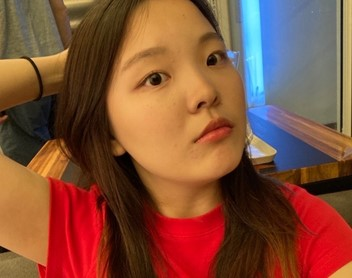

In [15]:
from IPython.display import display
image_path = "./self_test_image.jpg"
question = input("Enter your question: ")

# 답변 생성
answer = generate_answer(model, image_path, question)
print("Answer:", answer)
image = Image.open(image_path)
display(image)